# Getting Started

En el presente _Notebook_ vamos a desarrollar un sistema de recomendación Item-Item con la libreria _Lenskit_ similar al implementado en el laboratorio 1 con _Scikit-Surprise_. Este Notebook se apoya, traduce y explica el material presente en la documentación de la libreria para nuestro contexto. 

__Referencias__:
Michael D. Ekstrand. 2020. LensKit for Python: Next-Generation Software for Recommender Systems Experiments. In _Proceedings of the 29th ACM International Conference on Information and Knowledge Management_ (CIKM ‘20). DOI:10.1145/3340531.3412778. arXiv:1809.03125 [cs.IR]. Recuperado de: https://lkpy.readthedocs.io/en/stable/GettingStarted.html


## Instalación de liberias

Importar Lenskit

In [1]:
!pip install lenskit

     |████████████████████████████████| 81kB 4.8MB/s 
     |████████████████████████████████| 20.7MB 47.2MB/s 
     |████████████████████████████████| 133kB 43.1MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219266 sha256=50fffd7d5959828d8e3ba24eb8fcb9759330bc83d910adb58d3bca081923a320
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


Vamos a utilizar el mismo dataset _MovieLens 100k Database_. Con ayuda del paquete __wget__ realizamos la descargar

In [2]:
%%!
wget -q -O ml-100k.zip http://files.grouplens.org/datasets/movielens/ml-100k.zip

['Archive:  ml-100k.zip']

In [10]:
# Descomprimir los archivos
!unzip /content/ml-100k.zip -d /content/
#!pwd

Archive:  /content/ml-100k.zip
   creating: /content/ml-100k/
  inflating: /content/ml-100k/allbut.pl  
  inflating: /content/ml-100k/mku.sh  
  inflating: /content/ml-100k/README  
  inflating: /content/ml-100k/u.data  
  inflating: /content/ml-100k/u.genre  
  inflating: /content/ml-100k/u.info  
  inflating: /content/ml-100k/u.item  
  inflating: /content/ml-100k/u.occupation  
  inflating: /content/ml-100k/u.user  
  inflating: /content/ml-100k/u1.base  
  inflating: /content/ml-100k/u1.test  
  inflating: /content/ml-100k/u2.base  
  inflating: /content/ml-100k/u2.test  
  inflating: /content/ml-100k/u3.base  
  inflating: /content/ml-100k/u3.test  
  inflating: /content/ml-100k/u4.base  
  inflating: /content/ml-100k/u4.test  
  inflating: /content/ml-100k/u5.base  
  inflating: /content/ml-100k/u5.test  
  inflating: /content/ml-100k/ua.base  
  inflating: /content/ml-100k/ua.test  
  inflating: /content/ml-100k/ub.base  
  inflating: /content/ml-100k/ub.test  


Importar paquetes de Lenskit as como la libreria pandas para manipular los datos

In [11]:
from lenskit.datasets import ML100K
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn as knn
from lenskit import topn

import pandas as pd

## Cargar los datos

El paquete Lenskit nos proporciona una clase para cargar el dataset. Vamos a usarla, como parametro enviamos la ruta de la carpeta del dataset

In [12]:
ml100k = ML100K('ml-100k')
ratings = ml100k.ratings
ratings.head()

,user,item,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


## Definición de algoritmos

Vamos a utilizar y evaluar dos algoritmos. El primero (algo_ii) es un algoritmo Item-Item con un grupo de evaluación de 20 vecinos, el cual utiliza K Nearest Neightbors (KNN). 

El segundo Alternating Least Square (algo_als) es un algoritmo para factorización de matrices utilizado en la construcción de sistemas de recomendación

In [13]:
algo_ii = knn.ItemItem(20)
algo_als = als.BiasedMF(50)

## Ejecutar la evaluación

En Lenskit, la evaluación del modelo se realiza en dos pasos:

1. Generar recomendaciones a partir de los datos
2. Evaluar las recomendaciones generadas

Si no se posee suficiente memoria para correr el modelo, es posible realizar este proceso de evaluación de metricas mientras se generan recomendaciones. No obstante, no lo haremos así en este tutorial.

En primer lugar vamos a definir una función para generar las recomendaciones utilizando un algoritmo sobre un subconjunto (partición) del conjunto de datost. Las entradas seran el algoritmo a usar, el conjunto de entrenamiento, el conjunto test y su resultado sera la recomendación.

**Note:** Antes de ajustar el modelo con el algoritmo, clonamos el objeto que lo define. En algunos casos se presentan errores debido a la mutación que puede tener el objeto.

**Note 2:** Nuestro algoritmo no implementa la interfaz `Recommender` por ello ajustamos nuestra implementación. Esta interfaz determina el selector de candidatos por defecto.

Con este contexto, nuestra función es:

In [14]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

Con nuestra función definida, iteramos sobre los datos y los dos algoritmos y generamos recomendaciones:

In [15]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('ALS', algo_als, train, test))

/usr/local/lib/python3.7/dist-packages/lenskit/algorithms/item_knn.py:119: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  b = blocks[bi]
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Con los resultados obtenidos, construimos un único data frame que los agrupe:

In [16]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs.head()

,item,score,user,rank,Algorithm
0,1449,4.592536,6,1,ItemItem
1,1398,4.578079,6,2,ItemItem
2,603,4.565142,6,3,ItemItem
3,1642,4.460632,6,4,ItemItem
4,169,4.414575,6,5,ItemItem


Para computar nuestro analisis y evaluación de metricas debemos concatenar tambien el conjunto de test en el mismo data frame:

In [17]:
test_data = pd.concat(test_data, ignore_index=True)

Vamos a analizar las recomendaciones generadas con la utilidad `RecListAnalysis`.  Esta utilidad realiza la tarea ardua de asegurarse que el conjunto de prueba y las recomendaciones generadas se encuentren alineadas.

En este caso, asumimos que cada usuario aparece solo una vez en cada ejecución del algoritmo. Debido a que nuestro metodo de partición se enfoca en usuarios, no deberia haber ningún problema.

In [18]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.head()

nrecs      ndcg
Algorithm user                 
ALS       1     100.0  0.283965
          2     100.0  0.064179
          3     100.0  0.039360
          4     100.0  0.000000
          5     100.0  0.116733

Con este resultado, ya podemos obtener nuestras metricas

In [19]:
results.groupby('Algorithm').ndcg.mean()

Algorithm
ALS         0.124460
ItemItem    0.096843
Name: ndcg, dtype: float64

Finalmente, las representamos en un grafico de barras

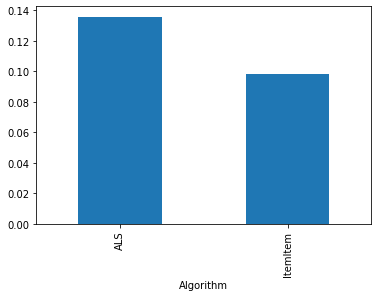

In [ ]:
results.groupby('Algorithm').ndcg.mean().plot.bar()